## Load and Process Data

In [1]:
# load Jena Weather dataset
# (data from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)
import os

data_path = os.path.join(os.getcwd(), 'jena_climate_2009_2016.csv')
file = open(data_path)
data = file.read()
file.close()

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

print(headers)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
# convert data to np array
import numpy as np

float_data = np.zeros((len(lines), len(headers) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i] = values

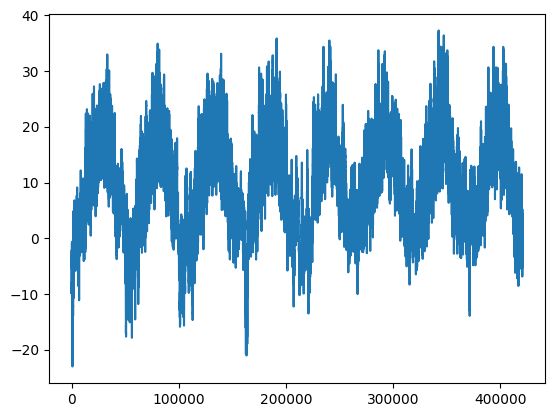

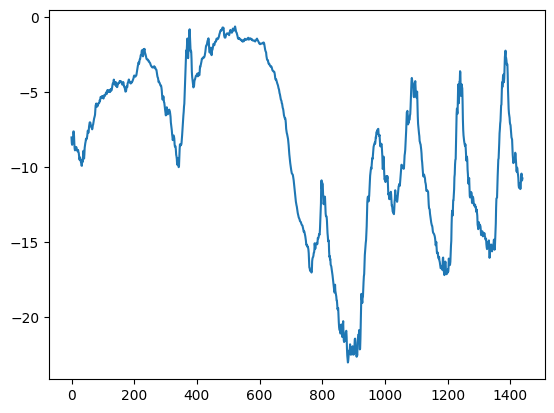

In [3]:
# plot temperature from timeseries (timestep every 10 min)
from matplotlib import pyplot as plt

temp = float_data[:, 1] # temperature in C
plt.plot(range(len(temp)), temp)
plt.figure()
plt.plot(range(1440), temp[:1440]) # first 10 days

In [4]:
# normalize data based on first 200,000 data points (only training data)
mean = float_data[:200_000].mean(axis=0)
std = float_data[:200_000].std(axis=0)
float_data -= mean
float_data /= std

In [5]:
# function to create generator to return timeseries samples and their targets
def generator(data, lookback, delay, min_index=None, max_index=None,
              shuffle=False, batch_size=128, step=6):
    if min_index == None:
        min_index = 0
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros(len(rows))
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        yield samples, targets

In [6]:
# create training / validation / test generators
lookback = 1440
delay = 144
batch_size = 128
step = 6

train_gen = generator(float_data, lookback=lookback, delay=delay, max_index=200_000, shuffle=True)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200_001, max_index=300_000)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300_001)

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

## Baseline Approaches

In [7]:
# baseline approach: temp in 24hr will be the same
# evaluated with mean absolute error (MAE)
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        batch_mae = np.mean(np.abs(targets - preds))
        batch_maes.append(batch_mae)
    print(np.mean(batch_maes))

evaluate_naive_method() # result corresponds to about 2.57 C (when multiplied by std)

0.2897359729905488


In [ ]:
# basic Neural Net approach
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

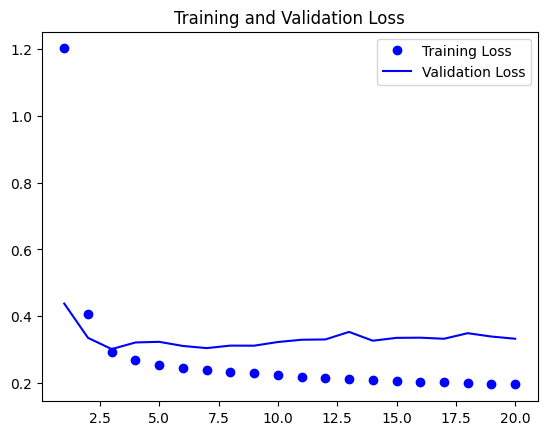

In [10]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# basic RNN approach (GRU)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

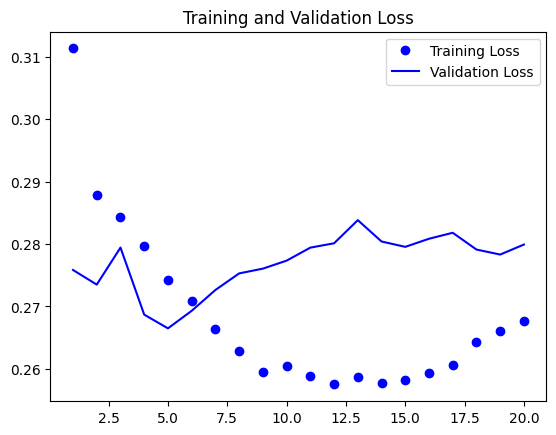

In [13]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Recurrent Dropout

In [ ]:
# Recurrent Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

import tensorflow as tf
with tf.device('/CPU:0'): # kernel was crashing with GPU
    history = model.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=40,
                        validation_data=val_gen,
                        validation_steps=val_steps)

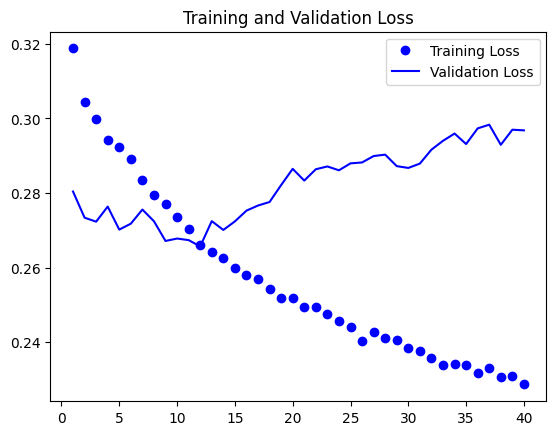

In [9]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Stacking RNN Layers

In [ ]:
# Stacking RNN
# Recurrent Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

import tensorflow as tf
with tf.device('/CPU:0'): # kernel was crashing with GPU
    history = model.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=40,
                        validation_data=val_gen,
                        validation_steps=val_steps)

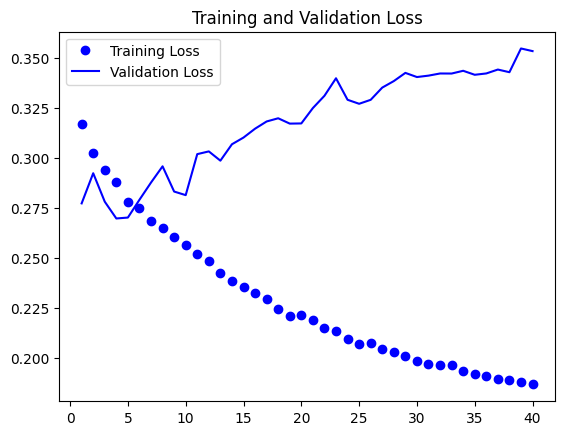

In [9]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## GRU on Reversed Sequence

In [8]:
# Reversed Generator
def generator_rev(data, lookback, delay, min_index=None, max_index=None,
              shuffle=False, batch_size=128, step=6):
    if min_index == None:
        min_index = 0
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros(len(rows))
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_rev = generator_rev(float_data, lookback=lookback, delay=delay, max_index=200_000, shuffle=True)
val_gen_rev = generator_rev(float_data, lookback=lookback, delay=delay, min_index=200_001, max_index=300_000)

In [ ]:
# basic RNN approach (GRU) on reversed Weather data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen_rev,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen_rev,
                    validation_steps=val_steps)

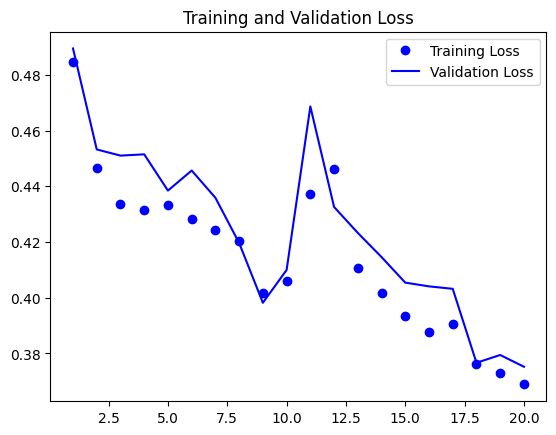

In [10]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## LSTM on Reversed Sequence (IMDB)

In [ ]:
# LSTM on reversed IMDB data
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_features = 10_000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

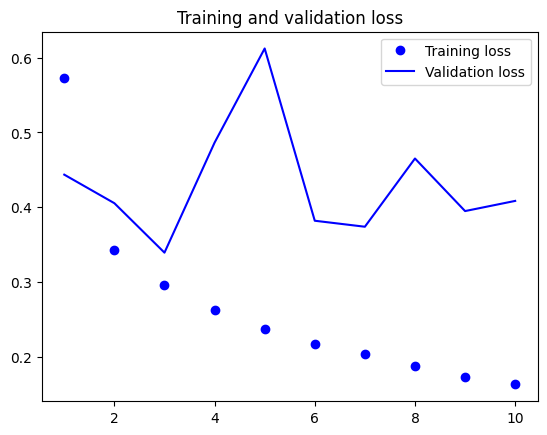

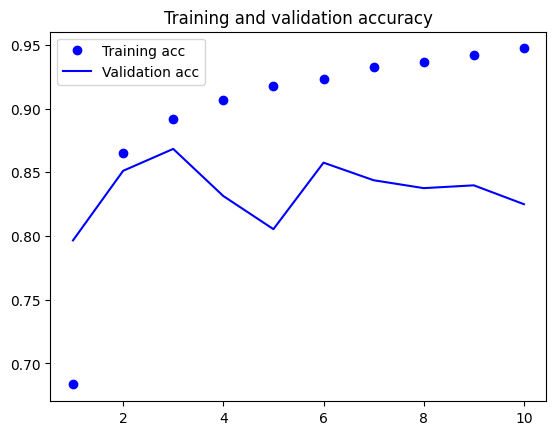

In [12]:
# plot training / validation loss and accuracy
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## Bidirectional LSTM (IMDB)

In [ ]:
# Bidirectional LSTM on IMDB data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

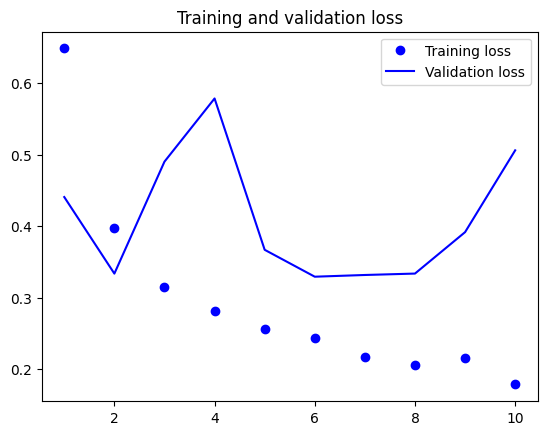

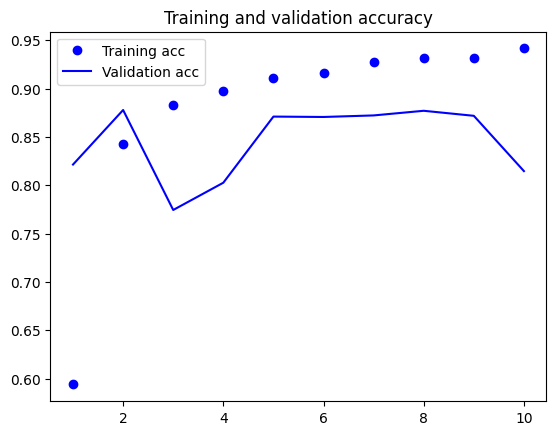

In [14]:
# plot training / validation loss and accuracy
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## Bidirectional GRU

In [ ]:
# Bidirectional LSTM on Weather
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


import tensorflow as tf
with tf.device('/CPU:0'): # fit was stalling with GPU, but CPU is faster on this one
    history = model.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=40,
                        validation_data=val_gen,
                        validation_steps=val_steps)

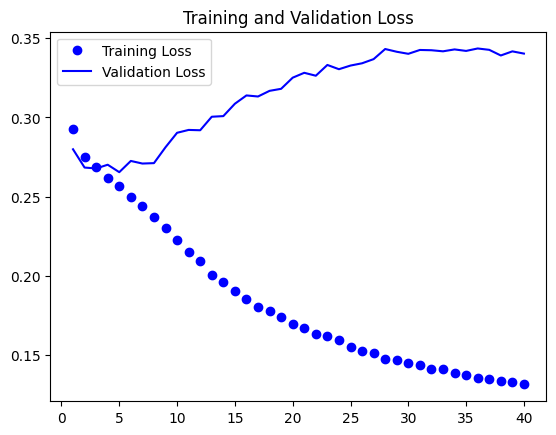

In [8]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [10]:
# Evaluate last model on test data
model.evaluate(test_gen, steps=test_steps)

929/929 [==============================] - 57s 61ms/step - loss: 0.3565


0.35649678111076355